In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
!pip install memory_profiler
import memory_profiler
import time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline


# Cargado de librerias

In [132]:
df = pd.read_feather('disp.feather') #Cargamos los datos

In [133]:
#Predictores con valores constantes
const_cols = df.columns[df.nunique() == 1]
print(const_cols)

Index(['pwat_ea3_1', 'spfh_2m3_1', 'tcolc_e3_1', 'tmin_2m2_1', 'tmin_2m4_1',
       'tmp_2m_3_1', 'ulwrf_t1_1', 'uswrf_s1_1'],
      dtype='object')


Estas columnas hay que eliminarlas, ya que al ser constantes no nos van a aportar información en el estudio, vamos a ver la información y la forma de nuestro dataset

In [134]:
# Explorar el dataframe
print(df.shape)
print(df.columns)

for columna, tipo in df.dtypes.items():
    print(f"{columna}: {tipo}")


print(df.iloc[:,:].describe().std)

(4380, 76)
Index(['salida', 'apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1',
       'apcp_sf5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1',
       'dlwrf_s5_1', 'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1',
       'dswrf_s5_1', 'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1',
       'pres_ms5_1', 'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1',
       'pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1',
       'spfh_2m5_1', 'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1',
       'tcdc_ea5_1', 'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1',
       'tcolc_e5_1', 'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1',
       'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1',
       'tmin_2m5_1', 'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1',
       'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1',
       'tmp_sfc5_1', 'ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf

In [135]:
# Calcular el número de valores faltantes por columna
missing_values_count = df.isnull().sum()

# Calcular el porcentaje de valores faltantes por columna
missing_values_percent = 100 * missing_values_count / len(df)

# Crear un dataframe con el número y el porcentaje de valores faltantes
missing_values_df = pd.DataFrame({'count': missing_values_count, 'percent': missing_values_percent})

# Mostrar el dataframe ordenado por porcentaje de forma descendente
missing_values_df.sort_values('percent', ascending=False)

,count,percent
pwat_ea3_1,4030,92.009132
uswrf_s1_1,3898,88.995434
apcp_sf3_1,876,20.000000
tmp_sfc3_1,657,15.000000
dlwrf_s5_1,657,15.000000
...,...,...
tcolc_e2_1,0,0.000000
apcp_sf1_1,0,0.000000
tcolc_e4_1,0,0.000000
tcolc_e5_1,0,0.000000


Vemos que tenemos dos columnas que superar el 80% de datos faltantes, por lo que deberíamos de eliminarlas, ya que posiblemente lo único que nos pueden aportar es ruido

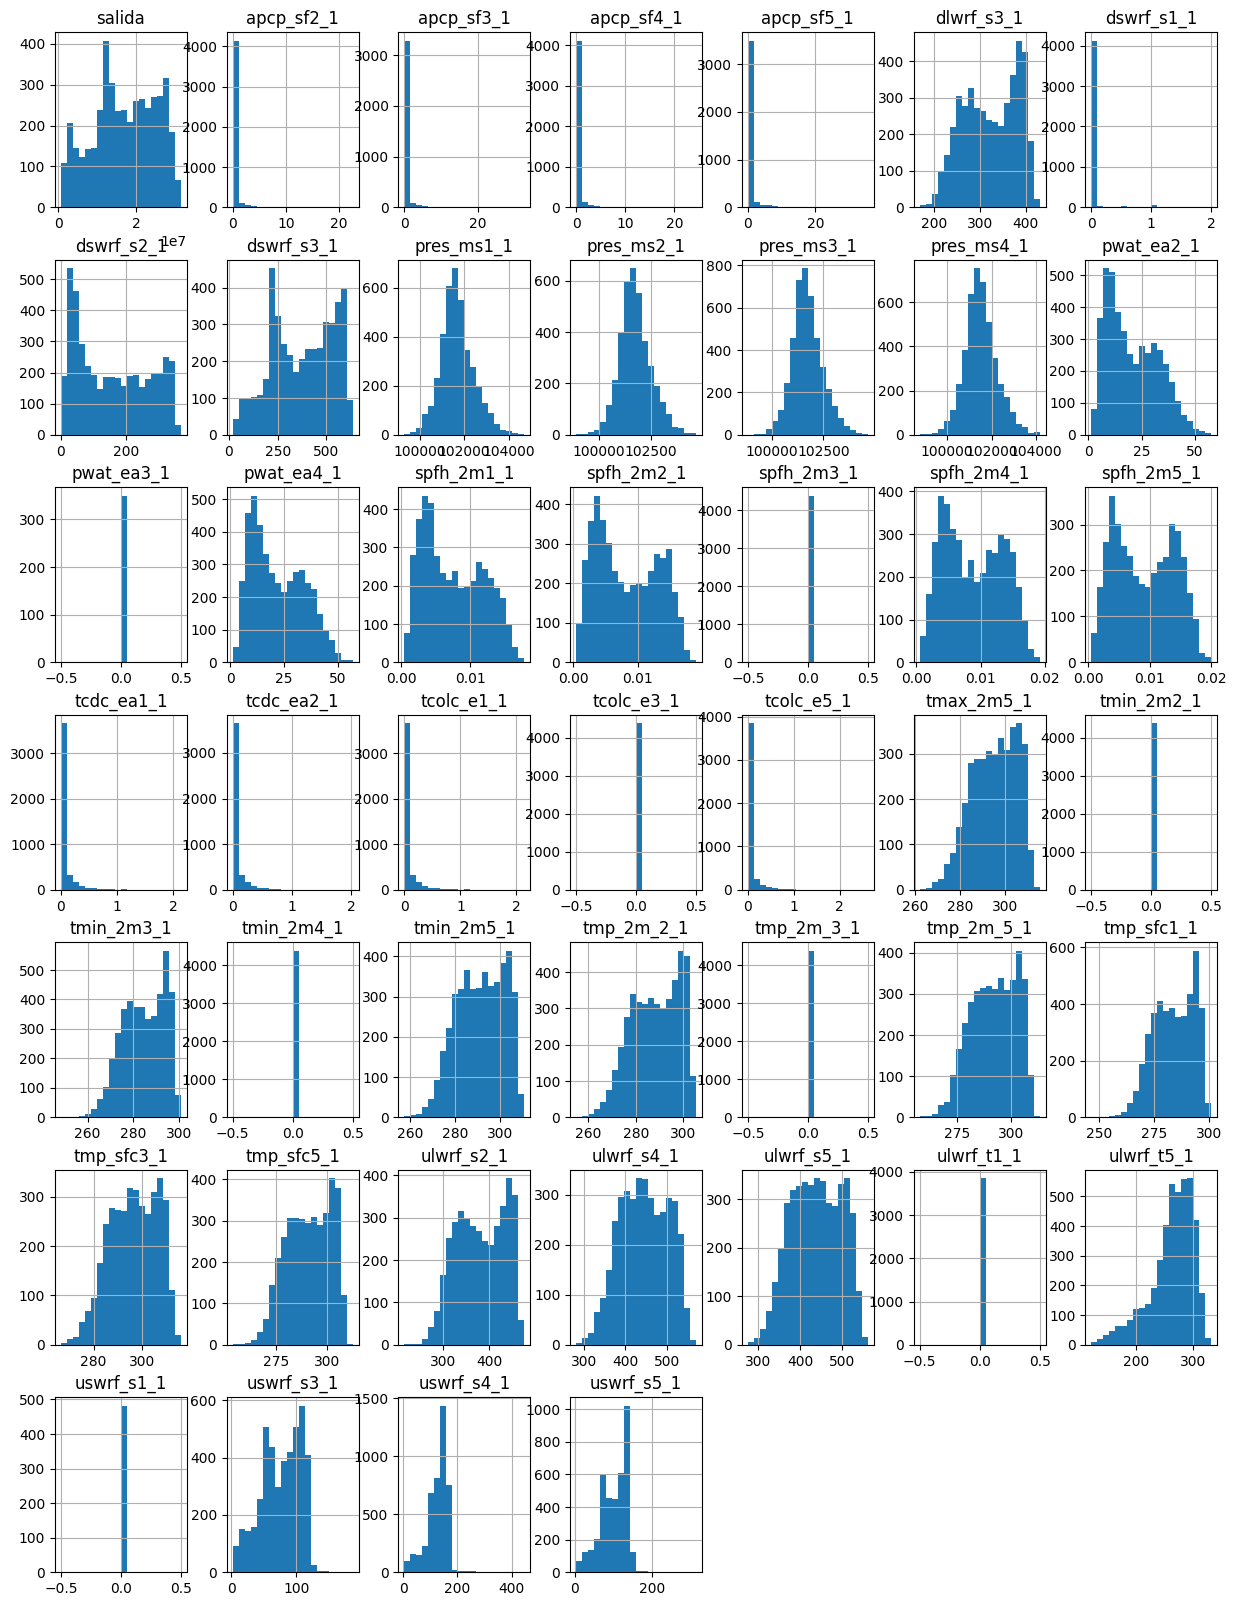

In [136]:
#Histogramas para las variables númercias
df.hist(bins = 20,figsize=(15,20))
plt.show()

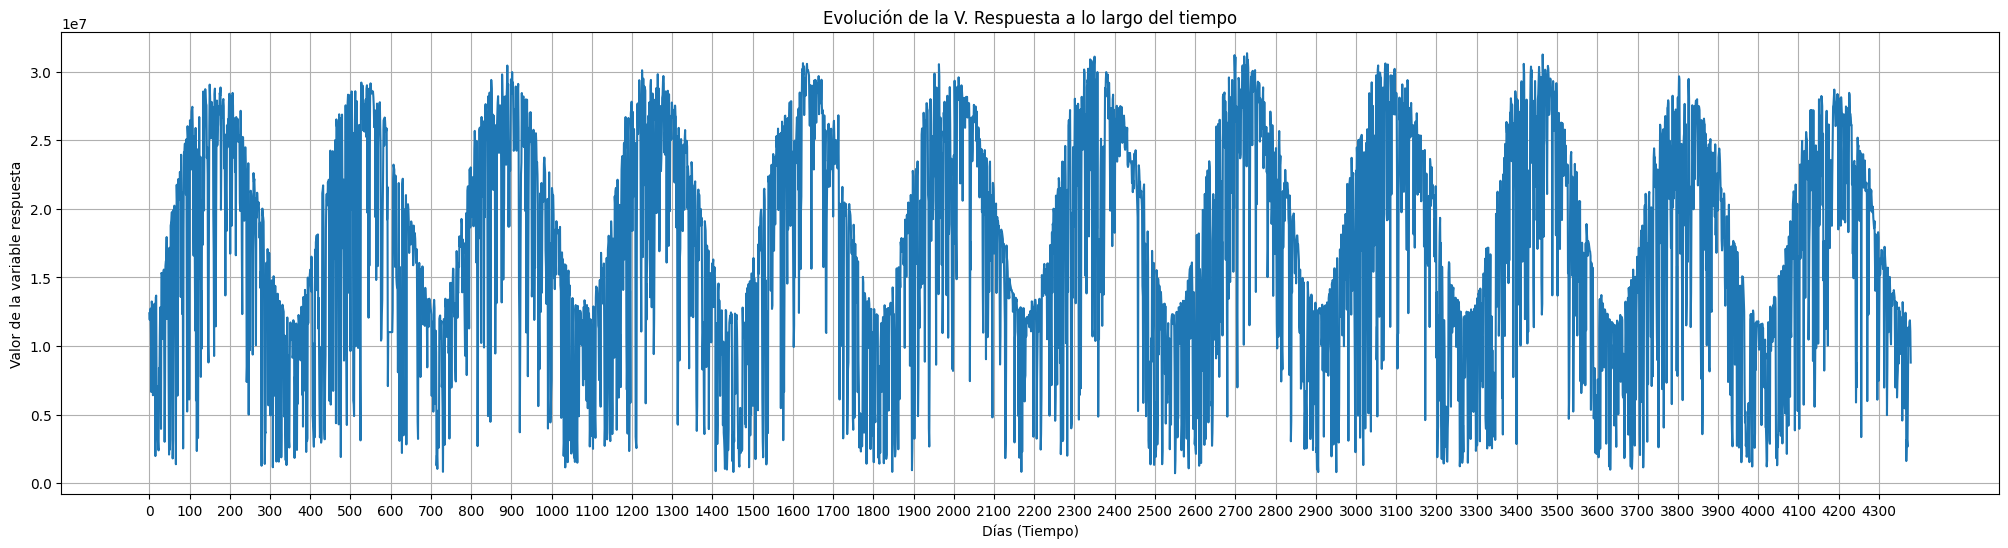

In [137]:
plt.figure(figsize=(25, 6))
plt.plot(df.iloc[:, 0])
plt.title('Evolución de la V. Respuesta a lo largo del tiempo')
plt.xlabel('Días (Tiempo)')
plt.ylabel('Valor de la variable respuesta')
plt.grid(True)
plt.xticks(np.arange(0, len(df), 100))
plt.show()

Vemos una estacionalidad bastante marcada, por lo que vamos a tener que tener en cuenta que nos encontramos ante una serie temporal dónde el tiempo va a ser bastante importante en el estudio, principalmente a lo hora de dividir nuestros datos

# Preprocesado

Empezamos eliminando las columnas de nuestro data.frame que son constante y que tienen valores faltantes por encima de los valores comentados anteriores, además guardamos nuestra variable respuesta en una array

In [138]:
x = df.drop(['salida','pwat_ea3_1', 'spfh_2m3_1', 'tcolc_e3_1', 'tmin_2m2_1', 'tmin_2m4_1', 'tmp_2m_3_1', 'ulwrf_t1_1', 'uswrf_s1_1'], axis = 1)
y = df['salida']
print(x.info())
print("\n")
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   apcp_sf1_1  4380 non-null   category
 1   apcp_sf2_1  4380 non-null   float64 
 2   apcp_sf3_1  3504 non-null   float64 
 3   apcp_sf4_1  4380 non-null   float64 
 4   apcp_sf5_1  3767 non-null   float64 
 5   dlwrf_s1_1  3811 non-null   object  
 6   dlwrf_s2_1  4380 non-null   category
 7   dlwrf_s3_1  4380 non-null   float64 
 8   dlwrf_s4_1  4380 non-null   category
 9   dlwrf_s5_1  3723 non-null   object  
 10  dswrf_s1_1  4380 non-null   float64 
 11  dswrf_s2_1  4380 non-null   float64 
 12  dswrf_s3_1  4380 non-null   float64 
 13  dswrf_s4_1  4380 non-null   category
 14  dswrf_s5_1  4380 non-null   category
 15  pres_ms1_1  3854 non-null   float64 
 16  pres_ms2_1  3723 non-null   float64 
 17  pres_ms3_1  4380 non-null   float64 
 18  pres_ms4_1  4380 non-null   float64 
 19  pres_m

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, shuffle=False)
# Importante no hacerlo de forma aleatoria.

Vemos que ya tenemos todas las variables restantes

In [140]:
# Funciones para clasificar columnas numéricas y categóricas
def tipos (x,tipo):
  columns=[col for col in x.columns if x[col].dtype==tipo]
  return columns


def no_tipos (x,tipo):
  columns=[col for col in x.columns if x[col].dtype!=tipo]
  return columns


# Obtener columnas numéricas
numericas=tipos(x,'float64')
print(len(numericas))
print(numericas)

# Obtener columnas categóricas
categoricas=no_tipos(x,'float64')
print(len(categoricas))
print(categoricas)

37
['apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1', 'dlwrf_s3_1', 'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pwat_ea2_1', 'pwat_ea4_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m4_1', 'spfh_2m5_1', 'tcdc_ea1_1', 'tcdc_ea2_1', 'tcolc_e1_1', 'tcolc_e5_1', 'tmax_2m5_1', 'tmin_2m3_1', 'tmin_2m5_1', 'tmp_2m_2_1', 'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc3_1', 'tmp_sfc5_1', 'ulwrf_s2_1', 'ulwrf_s4_1', 'ulwrf_s5_1', 'ulwrf_t5_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']
30
['apcp_sf1_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s4_1', 'dlwrf_s5_1', 'dswrf_s4_1', 'dswrf_s5_1', 'pres_ms5_1', 'pwat_ea1_1', 'pwat_ea5_1', 'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1', 'tcolc_e2_1', 'tcolc_e4_1', 'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmin_2m1_1', 'tmp_2m_1_1', 'tmp_2m_4_1', 'tmp_sfc2_1', 'tmp_sfc4_1', 'ulwrf_s1_1', 'ulwrf_s3_1', 'ulwrf_t2_1', 'ulwrf_t3_1', 'ulwrf_t4_1', 'uswrf_s2_1']


Vemos que tenemos 45 predictores numéricos y 31 categóricos

In [141]:
imputer_learner_reg=KNeighborsRegressor() #Cargamos el learner para los datos numéricos
imputer_learner_class= KNeighborsClassifier() #Cargamos el learner para los datos categóricos
regresor = KNeighborsRegressor() #Cargamos el regresor simple que va a ser un KNN


num_pipeline= Pipeline([ #Creamos la pipeline para imputar los valores faltantes numéricos con el KNN de regresión
    ("imputer",IterativeImputer(estimator=imputer_learner_reg)),
    ("scaler",StandardScaler())
])

cat_pipeline= Pipeline([ #Creamos la pipeline para imputar los valores faltantes categóricps con el KNN de clasificación
    ("encoder",OneHotEncoder(sparse_output=False, handle_unknown = "ignore")), #Además les aplicamos el OneHotEncoder
    ("imputer",IterativeImputer(estimator=imputer_learner_class))

])

preprocessor= ColumnTransformer([ #Añadimos las variables de cada tipo, a las que les vamos a aplicar sus correspondientes pipas
    ("num", num_pipeline, [*numericas]),
    ("cat", cat_pipeline,[*categoricas])
])


In [142]:
preprocessor.fit(X_train) #Le aplicamos la pipeline de preproceso a nuestros datos de entrenamiento

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(estimator=KNeighborsRegressor())),
                                                 ('scaler', StandardScaler())]),
                                 ['apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1',
                                  'apcp_sf5_1', 'dlwrf_s3_1', 'dswrf_s1_1',
                                  'dswrf_s2_1', 'dswrf_s3_1', 'pres_ms1_1',
                                  'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1',
                                  'pwat_ea2_1', 'pwat_ea4_1', 'spfh_2m1_1',
                                  'spfh_2...
                                  'dlwrf_s4_1', 'dlwrf_s5_1', 'dswrf_s4_1',
                                  'dswrf_s5_1', 'pres_ms5_1', 'pwat_ea1_1',
                                  'pwat_ea5_1', 'tcdc_ea3_1', 'tcdc_ea4_1',
                                  'tcdc_ea5_1', 'tcolc_e2_1', 'tcolc_e4_1',
                                  'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1',
                                  'tmax_2m4_1', 'tmin_2m1_1', 'tmp_2m_1_1',
                                  'tmp_2m_4_1', 'tmp_sfc2_1', 'tmp_sfc4_1',
                                  'ulwrf_s1_1', 'ulwrf_s3_1', 'ulwrf_t2_1',
                                  'ulwrf_t3_1', 'ulwrf_t4_1', 'uswrf_s2_1'])])

Ahora ajusamos la pipeline, que nos debe de devolver que los mejores hiperparámetros son con los que hemos ajustado anteriormente

In [143]:
preprocessor= Pipeline([
    ("preprocessor", preprocessor), # Preprocesar los datos con el transformador de columnas
    ('regresor', regresor)
])
# Hiperparámetros
param_grid = {
    'preprocessor__num__imputer': [IterativeImputer(estimator = imputer_learner_reg), SimpleImputer(strategy='mean')],
    'preprocessor__num__scaler': [StandardScaler(),RobustScaler(), MaxAbsScaler()],
    'preprocessor__cat__imputer': [IterativeImputer(estimator = imputer_learner_class), SimpleImputer(strategy='most_frequent')],
    #'regresor' : [KNeighborsRegressor(), DecisionTreeRegressor(), SVR(kernel='linear'), SVR(kernel='rbf')]
    }


Creamos una función que nos entrene y ajuste la pipa que queremos, además de que también nos devuelva el tiempo de ajuste y la memoria usada, esto va a ser muy util de cara a no tener que repetir el mismo código a lo largo del trabajo

In [144]:
def aplicar_pipa(X_train,Y_train,X_test,Y_test,pipa,hiperparametros,cv,metodo=GridSearchCV):

    if metodo == GridSearchCV:
        ajuste = GridSearchCV(pipa, hiperparametros, cv=cv, scoring="r2")
    else:
        ajuste = RandomizedSearchCV(pipa, hiperparametros, cv=cv, scoring="r2",random_state=100453131)

    @memory_profiler.profile
    def train_model(ajuste, X_train, Y_train):
        # Entrenar el modelo con el GridSearch con el conjunto de entrenamiento
        ajuste.fit(X_train, Y_train)

    # Guardar el tiempo antes de ejecutar la función de entrenamiento
    start_time = time.time()

    # Ejecutar la función de entrenamiento
    train_model(ajuste, X_train, Y_train)

    # Guardar el tiempo después de ejecutar la función de entrenamiento
    end_time = time.time()

    # Calcular el tiempo de CPU total
    cpu_time = end_time - start_time

    # Mostrar el tiempo de CPU total
    print(f"El tiempo de CPU total es {cpu_time:.2f} segundos")

    # Obtener el diccionario de resultados de la validación cruzada
    cv_results = ajuste.cv_results_

    # Mostrar el tiempo medio de ajuste y el tiempo medio de puntuación para cada configuración de parámetros
    for i in range(len(cv_results["params"])):
        print(f"Configuración de parámetros {i+1}: {cv_results['params'][i]}")
        print(f"Tiempo medio de ajuste: {cv_results['mean_fit_time'][i]:.2f} segundos")
        print(f"Tiempo medio de puntuación: {cv_results['mean_score_time'][i]:.2f} segundos")
        print()
    # Obtener el uso de memoria máximo durante la ejecución de la función de entrenamiento
    max_memory = max(memory_profiler.memory_usage((train_model, (ajuste, X_train, Y_train))))

    # Mostrar el uso de memoria máximo
    print(f"El uso de memoria máximo es {max_memory:.2f} MiB")

    # Mostrar los mejores parámetros encontrados por el GridSearch
    print(f"Los mejores parámetros son: {ajuste.best_params_}")
    print(f"La precision del modelo es: {ajuste.best_score_}")# R^2 inteno
    # Ajusta el modelo con los mejores hiperparámetros en los datos de entrenamiento
    best_model= ajuste.best_estimator_
    best_model.fit(X_train, Y_train)

    # Realiza las predicciones en el conjunto de prueba
    y_pred = best_model.predict(X_test)

    R_2 = r2_score(Y_test,y_pred)#R^2 externo
    print('El R^2 para el mejor modelo es',R_2)# Tienen que ser similaraes los R^2

In [145]:
tscv = TimeSeriesSplit(n_splits = 3)

aplicar_pipa(X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test,pipa=preprocessor,hiperparametros=param_grid,cv=tscv, metodo=GridSearchCV)

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_24904\3059229830.py
El tiempo de CPU total es 129.30 segundos
Configuración de parámetros 1: {'preprocessor__cat__imputer': IterativeImputer(estimator=KNeighborsClassifier()), 'preprocessor__num__imputer': IterativeImputer(estimator=KNeighborsRegressor()), 'preprocessor__num__scaler': StandardScaler()}
Tiempo medio de ajuste: 5.01 segundos
Tiempo medio de puntuación: 0.80 segundos

Configuración de parámetros 2: {'preprocessor__cat__imputer': IterativeImputer(estimator=KNeighborsClassifier()), 'preprocessor__num__imputer': IterativeImputer(estimator=KNeighborsRegressor()), 'preprocessor__num__scaler': RobustScaler()}
Tiempo medio de ajuste: 4.61 segundos
Tiempo medio de puntuación: 0.74 segundos

Configuración de parámetros 3: {'preprocessor__cat__imputer': IterativeImputer(estimator=KNeighborsClassifier()), 'preprocessor__num__imputer': IterativeImputer(estimator=KNeighborsRegressor()), 'preprocessor__num__scaler':

Ajustamos ahora lo métodos ensembles con sus hiperparametros base

In [ ]:
regresor =KNeighborsRegressor()
param_grid = {
    'regresor' : [SVR(kernel='linear'), SVR(kernel='rbf')]
}

In [ ]:
aplicar_pipa(X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test,pipa=preprocessor,hiperparametros=param_grid,cv=tscv, metodo=GridSearchCV)

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_4720\1223261845.py
El tiempo de CPU total es 32.88 segundos
Configuración de parámetros 1: {'regresor': SVR(kernel='linear')}
Tiempo medio de ajuste: 3.84 segundos
Tiempo medio de puntuación: 0.63 segundos

Configuración de parámetros 2: {'regresor': SVR()}
Tiempo medio de ajuste: 3.75 segundos
Tiempo medio de puntuación: 0.78 segundos

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_4720\1223261845.py
El uso de memoria máximo es 802.05 MiB
Los mejores parámetros son: {'regresor': SVR(kernel='linear')}
La precision del modelo es: -0.019255231247345517
El R^2 para el mejor modelo es -0.0012717554342918103


Ahora a estos modelos les ajustamos hiperparámetros

In [ ]:
param_grid = [
    {
        'regresor' : [KNeighborsRegressor()],
        'regresor__n_neighbors' : [3,7,9,13,15],
    },
    {
        'regresor':[DecisionTreeRegressor()],
        'regresor__max_depth': [2,4,6,8,10],
        'regresor__min_samples_split': [10,50,100],
    },
    {
        'regresor': [SVR(kernel='linear')],
        'regresor__C': [0.1,1,10,100],
    },
    {   'regresor': [SVR(kernel='rbf')],
        'regresor__C': [0.1,1,10,100],
        'regresor__gamma':['scale','auto',0.0001,0.1,1,10]
    }

]

In [ ]:
aplicar_pipa(X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test,pipa=preprocessor,hiperparametros=param_grid,cv=tscv, metodo=GridSearchCV)

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_4720\1223261845.py
El tiempo de CPU total es 824.53 segundos
Configuración de parámetros 1: {'regresor': KNeighborsRegressor(), 'regresor__n_neighbors': 3}
Tiempo medio de ajuste: 5.37 segundos
Tiempo medio de puntuación: 0.82 segundos

Configuración de parámetros 2: {'regresor': KNeighborsRegressor(), 'regresor__n_neighbors': 7}
Tiempo medio de ajuste: 5.03 segundos
Tiempo medio de puntuación: 0.91 segundos

Configuración de parámetros 3: {'regresor': KNeighborsRegressor(), 'regresor__n_neighbors': 9}
Tiempo medio de ajuste: 5.37 segundos
Tiempo medio de puntuación: 0.85 segundos

Configuración de parámetros 4: {'regresor': KNeighborsRegressor(), 'regresor__n_neighbors': 13}
Tiempo medio de ajuste: 4.60 segundos
Tiempo medio de puntuación: 0.80 segundos

Configuración de parámetros 5: {'regresor': KNeighborsRegressor(), 'regresor__n_neighbors': 15}
Tiempo medio de ajuste: 4.48 segundos
Tiempo medio de puntuación: 0

Vamos ahora con el caso de algoritmos no ensembles, dónde empezamos ajustando la pipa con los hiperparámetros de base

In [ ]:
regresor = KNeighborsRegressor()
pipeline= Pipeline([
    ("preprocessor", preprocessor), # Preprocesar los datos con el transformador de columnas
    ('regresor',regresor)
])

In [ ]:
param_grid= {
    'regresor': [RandomForestRegressor(random_state=100453131),XGBRegressor(random_state=100453131)]# Aleatorieidad porque el random forest utiliza predictores aleatorios para entrenar cada uno de los modelos
}

In [ ]:
aplicar_pipa(X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test,pipa=preprocessor,hiperparametros=param_grid,cv=tscv, metodo=RandomizedSearchCV)

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_4720\3064439430.py


c:\Users\jsm01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


El tiempo de CPU total es 131.10 segundos
Configuración de parámetros 1: {'regresor': RandomForestRegressor(random_state=100453131)}
Tiempo medio de ajuste: 24.16 segundos
Tiempo medio de puntuación: 0.72 segundos

Configuración de parámetros 2: {'regresor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=10045

c:\Users\jsm01\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


El uso de memoria máximo es 822.68 MiB
Los mejores parámetros son: {'regresor': RandomForestRegressor(random_state=100453131)}
La precision del modelo es: 0.8245863982090157
El R^2 para el mejor modelo es 0.8181988985557379


Ahora probamos a ajustar los hiperparámetros de los modelos anteriores

In [ ]:
param_grid = [
    {
        'regresor': [RandomForestRegressor(random_state=100453131)],
        'regresor__n_estimators': [10,50,100,200],
        'regresor__max_features':[0.5,'sqrt','log2']
    },
    {
        'regresor': [XGBRegressor(random_state=100453131)],
        'regresor__n_estimators': [10,50,100,200],
        'regresor__learning_rate': [0.01,0.1,0.2,0.3]#Tasa de aprendizaje shrinkage
    },
]

In [ ]:
aplicar_pipa(X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test,pipa=preprocessor,hiperparametros=param_grid,cv=tscv, metodo=GridSearchCV)

ERROR: Could not find file C:\Users\jsm01\AppData\Local\Temp\ipykernel_4720\1223261845.py
El tiempo de CPU total es 616.34 segundos
Configuración de parámetros 1: {'regresor': RandomForestRegressor(random_state=100453131), 'regresor__max_features': 0.5, 'regresor__n_estimators': 10}
Tiempo medio de ajuste: 5.32 segundos
Tiempo medio de puntuación: 0.64 segundos

Configuración de parámetros 2: {'regresor': RandomForestRegressor(random_state=100453131), 'regresor__max_features': 0.5, 'regresor__n_estimators': 50}
Tiempo medio de ajuste: 9.13 segundos
Tiempo medio de puntuación: 0.60 segundos

Configuración de parámetros 3: {'regresor': RandomForestRegressor(random_state=100453131), 'regresor__max_features': 0.5, 'regresor__n_estimators': 100}
Tiempo medio de ajuste: 14.05 segundos
Tiempo medio de puntuación: 0.65 segundos

Configuración de parámetros 4: {'regresor': RandomForestRegressor(random_state=100453131), 'regresor__max_features': 0.5, 'regresor__n_estimators': 200}
Tiempo medio d

# Hyperband

In [146]:
preprocessor.fit(X_train)
X_train_HB =  pd.DataFrame(preprocessor.transform(X_train))
X_test_HB =  pd.DataFrame(preprocessor.transform(X_test))
def loss_function(model, X, y):
  y_pred = model.predict(X)
  return  r2_score(y,y_pred)

ValueError: This KNeighborsRegressor estimator requires y to be passed, but the target y is None.

In [39]:
from sklearn.ensemble import RandomForestRegressor
# Definir la función que entrena y evalúa el modelo
def train_regresor(config):
  model = RandomForestRegressor(
      n_estimators=config["n_estimators"],
      max_features = config["max_features"],
      n_jobs=-1)
  model.fit(X_train_HB, Y_train)
  # Calcular la pérdida en el conjunto de prueba
  loss = loss_function(model, X_test_HB, Y_test)  # Crear un diccionario con la función de pérdida como valor y una clave arbitraria
  # Crear un diccionario con la función de pérdida como valor y una clave arbitraria
  metrics = {"loss": loss}
  # Reportar la pérdida a Ray Tune
  ray.train.report(metrics)

# Definir el espacio de búsqueda para los parámetros de Random Forest
param_grid= {
    "n_estimators": tune.grid_search([10,50,100,200]),
    "max_features": tune.grid_search([0.5,'sqrt','log2'])
}

# Iniciar el ajuste de hiperparámetros con Ray Tune y el algoritmo Hyperband
hyperband = tune.run(
  train_regresor, # La función que entrena y evalúa el modelo
  config=param_grid, # El espacio de búsqueda
  metric="loss", # La métrica a optimizar
  mode="max", # El modo de optimización (minimizar o maximizar)
  scheduler=tune.schedulers.HyperBandScheduler() # El planificador que implementa Hyperband
)
# Obtener el mejor resultado
best_trial = hyperband.get_best_trial(metric="loss", mode="max")
best_config = best_trial.config
best_loss = best_trial.last_result["loss"]

# Mostrar el mejor resultado
print(f"El mejor modelo encontrado tiene una pérdida de {best_loss:.4f} y usa {best_config['n_estimators']} árboles, y {best_config['max_features']} max_features")

2023-12-14 17:30:49,551	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-----------------------------------------------------------------------+
| Configuration for experiment     train_regresor_2023-12-14_17-30-49   |
+-----------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                |
| Scheduler                        HyperBandScheduler                   |
| Number of trials                 12                                   |
+-----------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_regresor_2023-12-14_17-30-49
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_regresor_2023-12-14_17-30-49`

Trial status: 12 PENDING
Current time: 2023-12-14 17:30:50. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------+
| Trial name                   status       n_estimators   max_features 

# Exportación del mejor modelo

Empezamos ajustandolo de la forma tradicional, es decir sin usar la función, de cara a poder guardarlo

In [29]:
param_grid = [
    {
        'regresor': [XGBRegressor(random_state=100453131)],
        'regresor__n_estimators': [50],
        'regresor__learning_rate': [0.1]#Tasa de aprendizaje shrinkage
    },
]
ajuste = GridSearchCV(preprocessor, param_grid, cv=tscv, scoring="r2")
ajuste.fit(X_train,Y_train)
best_model = ajuste.best_estimator_
best_model.fit(X_train, Y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(estimator=KNeighborsRegressor())),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['apcp_sf2_1', 'apcp_sf3_1',
                                                   'apcp_sf4_1', 'apcp_sf5_1',
                                                   'dlwrf_s3_1', 'dswrf_s1_1',
                                                   'dswrf_s2_1', 'dswrf_s3_1',
                                                   'pres_ms1_1', 'pres_ms2_1',
                                                   'pres_ms3_1', 'pres_ms4_1',
                                                   'pwat_ea2_1', '...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=50, n_jobs=None,
                              num_parallel_tree=None, random_state=100453131, ...))])

In [38]:
#Aplicar las transformaciones del preprocesado
from joblib import dump
X_transformada = best_model[:-1].transform(x) # Se aplica la pipa exceptuando el modelo

best_model[-1].fit(X_transformada,y) #Ajustar el modelo a los datos que acabamos de transformar
dump(best_model, "E-modelo.joblib") #Guardamos la pipa con el mejor modelo en un archivo joblib

['E-modelo.joblib']

EDA del fichero de las predicciones

In [39]:
df_competicion = pd.read_feather('compet.feather') #Cargamos los datos
df_competicion

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,...,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1
0,low,0.0,0.0,0.000000,0.000000,blue,low,275.618003,medium,blue,...,0.0,medium,high,high,262.813816,NaN,low,48.000000,105.727273,70.545455
1,low,0.0,NaN,0.000000,0.000000,blue,low,258.974701,low,red,...,0.0,medium,medium,high,255.737294,NaN,low,49.909091,109.181818,NaN
2,low,0.0,0.0,0.000000,0.000000,red,low,262.735166,medium,None,...,0.0,medium,medium,medium,217.005464,NaN,low,46.727273,84.636364,57.727273
3,low,0.0,NaN,0.000000,NaN,blue,medium,296.137074,medium,None,...,0.0,medium,medium,high,290.279308,NaN,low,44.454545,110.090909,76.000000
4,low,0.0,0.0,0.000000,0.000000,None,low,272.983784,medium,red,...,0.0,medium,high,high,274.339575,NaN,low,47.545455,107.818182,74.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,low,0.0,0.0,0.001818,0.010000,red,low,223.116305,low,red,...,0.0,medium,medium,medium,244.746790,NaN,low,65.909091,134.363636,NaN
729,low,0.0,0.0,0.000000,0.000000,red,low,217.702517,low,red,...,0.0,medium,medium,medium,233.310955,NaN,low,98.727273,206.000000,131.454545
730,low,0.0,NaN,0.000000,0.001818,red,low,223.671274,low,red,...,0.0,medium,medium,medium,223.848527,NaN,low,90.909091,188.454545,118.636364
731,low,0.0,NaN,0.000000,0.000000,red,low,217.747364,low,red,...,0.0,medium,medium,medium,253.922129,NaN,low,96.090909,191.636364,125.727273


In [103]:
print(df_competicion.shape)
print(df_competicion.columns)
print(df_competicion.dtypes)
print(df_competicion.describe())

(733, 75)
Index(['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1',
       'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1',
       'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1',
       'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1', 'pwat_ea5_1',
       'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1',
       'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1',
       'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1',
       'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1',
       'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1',
       'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1',
       'ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ul

In [104]:
#Número de valores faltantes por columna
missing_value_count = df_competicion.isnull().sum()
#Porcentaje de valores faltantes por columna
missing_values_percent = 100*missing_value_count/len(df_competicion)

#Dataframe con número y porcentaje de valores faltantes
missing_value_df = pd.DataFrame({'count':missing_value_count,'percent':missing_values_percent})
missing_value_df.sort_values('percent',ascending = False)

,count,percent
pwat_ea3_1,674,91.950887
uswrf_s1_1,652,88.949523
apcp_sf3_1,147,20.054570
pres_ms2_1,110,15.006821
tcdc_ea3_1,110,15.006821
...,...,...
apcp_sf2_1,0,0.000000
tcolc_e4_1,0,0.000000
tcolc_e5_1,0,0.000000
tmax_2m1_1,0,0.000000


In [105]:
# Contar el número de valores únicos en cada columna
num_unique = df_competicion.nunique()

# Seleccionar columnas con valores constantes
const_cols = num_unique[num_unique == 1].index.tolist()

print(const_cols)

['pwat_ea3_1', 'spfh_2m3_1', 'tcolc_e3_1', 'tmin_2m2_1', 'tmin_2m4_1', 'tmp_2m_3_1', 'ulwrf_t1_1', 'uswrf_s1_1']


(733, 75)
Index(['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1', 'apcp_sf4_1', 'apcp_sf5_1',
       'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1',
       'dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1',
       'pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1',
       'pwat_ea1_1', 'pwat_ea2_1', 'pwat_ea3_1', 'pwat_ea4_1', 'pwat_ea5_1',
       'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1',
       'tcdc_ea1_1', 'tcdc_ea2_1', 'tcdc_ea3_1', 'tcdc_ea4_1', 'tcdc_ea5_1',
       'tcolc_e1_1', 'tcolc_e2_1', 'tcolc_e3_1', 'tcolc_e4_1', 'tcolc_e5_1',
       'tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1',
       'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1',
       'tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1',
       'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1',
       'ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ul

Predicciones del archivo compet

In [97]:
#Aplicar las transformaciones del preprocesado
best_model[:-1].transform(df_competicion) # Se aplica la pipa exceptuando el modelo

pred_compet = best_model.predict(df_competicion)

#Guardar las predicciones en un archivo
df_predicciones = pd.DataFrame(pred_compet, columns=['Pred_compet'])
print(df_predicciones)
#Guardamos el dataframe en un archivo csv
df_predicciones.to_csv("E-pred.csv", index = False)


     Pred_compet
0     10981091.0
1     12206908.0
2      8432206.0
3     12066748.0
4     11799843.0
..           ...
728   10127545.0
729   11076803.0
730    9918875.0
731   13014037.0
732   12180132.0

[733 rows x 1 columns]


In [98]:
tiempo = list(range(1,734))
df1 = df_predicciones
df1['tiempo'] = tiempo
df1

,Pred_compet,tiempo
0,10981091.0,1
1,12206908.0,2
2,8432206.0,3
3,12066748.0,4
4,11799843.0,5
...,...,...
728,10127545.0,729
729,11076803.0,730
730,9918875.0,731
731,13014037.0,732


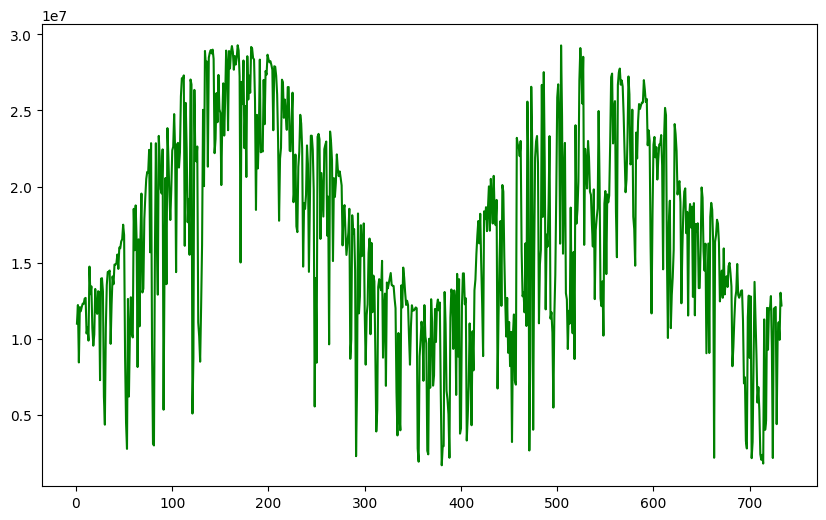

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(df1['tiempo'],df1['Pred_compet'], linestyle='-', color='green')
plt.show()

In [101]:
tiempo1 = list(range(1, 734 + (365*12)))
len(tiempo1)
df1 = pd.concat([df['salida'],df_predicciones['Pred_compet']], ignore_index=True)
df1 = pd.DataFrame(df1)
df1['tiempo'] = tiempo1
nuevos_nombres = ['salida','tiempo']
df1.columns = nuevos_nombres

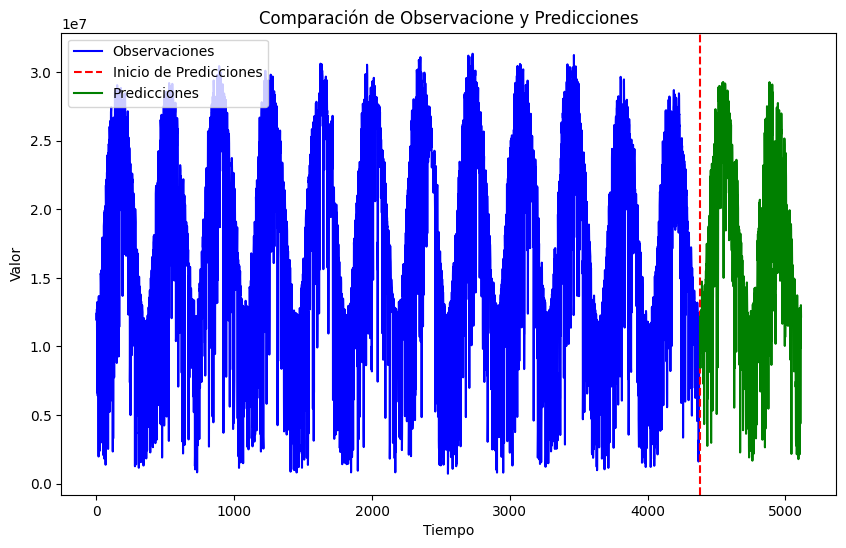

In [102]:
# Supongamos que 'columna1' es la primera serie temporal y 'columna2' es la segunda serie temporal
plt.figure(figsize=(10, 6))

# Graficar las primeras 4380 observaciones como Observaciones Reales
plt.plot(df1['tiempo'][:4380], df1['salida'][:4380], label='Observaciones', linestyle='-', color='blue')

# Dibujar una línea vertical para marcar el inicio de las predicciones
plt.axvline(x=4380, color='red', linestyle='--', label='Inicio de Predicciones')

# Graficar las predicciones a partir de la observación 4381
plt.plot(df1['tiempo'][4380:], df1['salida'][4380:], label='Predicciones', linestyle='-', color='green')

plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.title('Comparación de Observacione y Predicciones')
plt.legend(loc='upper left')  # Muestra las etiquetas de las series temporales
plt.show()